# The Conquest of American Inflation

## A simple model
The government dislikes inflation $y_t$ and unemployment $U_t$ away from $0$. It seeks to set inflation to minimize

$$ L = \sum_{t=0}^\infty \beta^t r_t $$

for

$$ r_t = \frac{1}{2}\mathbb{E}\left[ U_t^2 + y_t^2 \right] $$

The only thing it needs is a theory of how inflation and unemployment are linked.

### The true economy

In the true economy, unemployment is determined by

$$ U_t = U^\star -\theta \left( y_t - x_t \right) $$

where $x_t$ is the mean forecast of inflation by the private sector. $U^\star$ is the "natural" rate of unemployment.

Moreover, we will also make the apparently inocent assumption that inflation $y_t$ is the sum of the government choice of inflation $\hat{y}_t$ plus an iid normally distributed shock $v_t$

### Expectations
The plot thickens because the government holds a misspecified model and instead attempts to fit a distributed-lag Phillips curve of the form

$$ U_t = \kappa y_t + \gamma' X_t + \epsilon^C_t $$

For most of this lecture we will set $X_t = [U_{t-1}, \dots, U_{t-M_u}, y_{t-1}, \dots, y_{t-M_y}, 1]'$. This means that the government forecasts unemployment with current inflation as well as lagged unemployment, lagged inflation, and a constant term.

Each period, the government updates its estimate of $\kappa$ and $\gamma$. An implementation of recursive least squares is to set

$\begin{aligned}
\beta_t &= \beta_{t-1} + g_t R^{-1}_{X,t} X_t (U_t - \beta_{t-1}'X_t) \\
R_{X,t} &= R_{X,t-1} + g_t ( X_tX_t' - R_{X,t-1})\\
\end{aligned}$

where $\beta_t = [\kappa_t \; \gamma_t']'$. A key parameter is the "gain" parameter $g_t$, which governs the weight to be placed on newer observations. By setting $g_t = \frac{1}{t}$ one recovers the OLS scheme which weighs all observations the same. Setting the gain to a constant (or in general to a non square-summable sequence) makes the algorithm put more weight on recent observations, which can be useful if the analyst believes the data-generating process not to be stationary.

### The private sector's expectations
For the private sector, we consider three options. 
    1. Rational expectations
The simplest case is to make the private sector fully aware of the government's updating scheme and decision process. This amounts to setting $x_t = \hat{y}_t$ at all times.
    2. Simple adaptive expectations
This is the 1950's model. Here we make the private sector's new forecast a function of old forecasting errors. That is,
$$ x_t = x_{t-1} + (1-\lambda) (y_{t-1} - x_{t-1}) $$
    3. Recursive least squares
Here we endow the private sector with a similar forecasting scheme to the government's. We initialize $g^p_0$ and $R_{X,0}^p$ at (maybe) different points than the government's and may use a different lag structure.

## Code
To manage the different expectation-formation schemes, the `ConquestEconomy` type records three different instances of a `PLM` type. Each `PLM` instance holds information about the expectations of a particular agent, including those of Nature, also known as the actual law of motion of the system.

In [48]:
using QuantEcon, LinearAlgebra, Random

using Plots
pyplot()

mutable struct PLM
  κ::Float64          # Weight on current state (unemployment or inflation)
  γ::Vector{Float64}  # Weights on lagged states (unemployment + inflation + constant)

  Mu::Int64           # Lags on unemployment
  My::Int64           # Lags on inflation

  classic::Bool       # TRUE for predicting unemployment with the state, FALSE for predicting inflation

  g::Float64          # Gain parameter (only for constant-gain RLS)
  R::Matrix{Float64}  # Variance matrix (only for RLS)
  λ::Float64          # Adaptation parameter (only for simple adaptive expectations)
end

mutable struct ConquestEconomy
  δ::Float64          # Discount factor

  plm_g::PLM          # Government's perceived law of motion
  plm_p::PLM          # Private sector's perceived law of motion
  alm::PLM            # Actual (Nature's perceived) law of motion
    
  private_expectations::String

  σe::Float64         # Variance of cost-push shock
  σc::Float64         # Variance of inflation control shock
end

lags(plm::PLM) = length(plm.γ)

function sum_coeff(plm::PLM) # Finds the sum of coefficients on (current and) lagged inflation
  if plm.classic
    current_term = plm.κ
  else
    current_term = 0
  end
  return sum(plm.γ[plm.Mu+1:plm.Mu+plm.My]) + current_term
end

get_Ustar(alm::PLM) = alm.γ[end]
get_θ(alm::PLM) = -alm.κ
get_Ustar(ce::ConquestEconomy) = get_Ustar(ce.alm)
get_θ(ce::ConquestEconomy) = get_θ(ce.alm)

function make_ALM(plmg::PLM, plmp::PLM, Ustar::Float64, θ::Float64)
  Mu = max(plmg.Mu, plmp.Mu)
  My = max(plmg.My, plmp.My)
  γ = [zeros(Mu+My); Ustar]
  κ = -θ
  alm = PLM(κ, γ, Mu, My, true, 0.0, plmg.R, plmg.λ) # In the ALM, all the forecasting variables are irrelevant
  return alm
end

make_ALM(ce::ConquestEconomy, Ustar=get_Ustar(ce), θ=get_θ(ce)) = make_ALM(ce.plm_g, ce.plm_p, Ustar, θ)
function update_ALM!(ce::ConquestEconomy)
  ce.alm = make_ALM(ce)
  nothing
end

function ConquestEconomy(; 
  δ = 0.98,
  θ = 1.0,
  g = 0.05,
  λ = 0.5,  # λ is the weight on past observations for simple adaptive scheme
  σe = 0.5,
  σc = 0.5,
  Ustar = 5.0,
  classic = true,
  private_expectations = "rational",

  Mu = 1,
  My = 1,
  Mu_p = 2,
  My_p = 2
  )

  # Set arbitrary coefficients on past inflation and past unemployment
  γU = zeros(Mu)
  γy = zeros(My)
  γ = [γU; γy; 1]
  # For the induction hypothesis (weights on y's sum up to zero)
  κ = -sum(γy)
  R = zeros(Mu+My+1, Mu+My+1)

  plm_g = PLM(κ, γ, Mu, My, classic, g, R, λ)

  if private_expectations == "RLS"
    priv_gain = 0.01
  else
    Mu_p, My_p, priv_gain = Mu, My, g
  end
  Rp = zeros(Mu_p+My_p+1, Mu_p+My_p+1)
  classic = true # Always use the classical scheme for the private sector
  plm_p = PLM(1.0, [zeros(Mu_p+My_p);1], Mu_p, My_p, classic, priv_gain, Rp, λ)

  # True process
  alm = make_ALM(plm_g, plm_p, Ustar, θ)

  return ConquestEconomy(δ, plm_g, plm_p, alm, private_expectations, σe, σc)
end

ConquestEconomy

#### Some convenience functions to modify expectations schemes on the fly

In [49]:
function set_exp!(ce::ConquestEconomy, s::String=""; Mu=1, My=1, Mu_p=2, My_p=2)
  if s != "" && s != "rational" && s != "adaptive" && s != "RLS"
    println("WARNING: only 'rational', 'adaptive', and 'RLS' expectations allowed.")
  else
    if s == ""
      s = ce.private_expectations
    end    
    ce2 = ConquestEconomy(private_expectations = s, Mu=Mu, My=My, Mu_p=Mu_p, My_p=My_p)
    ce.plm_p = ce2.plm_p
    ce.plm_g = ce2.plm_g
    ce.private_expectations = s
    update_ALM!(ce)
  end
  nothing
end

function set_exp!(ce::ConquestEconomy, n::Int64=0; Mu=1, My=1, Mu_p=2, My_p=2)
    if n == 0
        set_exp!(ce, "", Mu=Mu, My=My, Mu_p=Mu_p, My_p=My_p)
    else
    sv = ["rational"; "adaptive"; "RLS"]
    set_exp!(ce, sv[n], Mu=Mu, My=My, Mu_p=Mu_p, My_p=My_p)
    end
    nothing
end

set_exp! (generic function with 3 methods)

#### Aside
If $M_u$ and $M_y$ are large, the government's problem, which contains $X_t$ in its state, can be difficult to manage. This is why we resort to the immense power of a linear-quadratic formulation.

### Main building block: LQ problems

We want to make our problem have the form of choosing controls $u_t$ in state $x_t$ to minimize

$$ V(x) = \mathbb{E}[ x'Rx + u'Qu + 2 u'Nx + \beta V(x') ] $$

subject to

$$ x' = Ax + Bu + Cw $$

where $w$ are unit-variance iid normal shocks.

#### Setting up our problem
The first step is to make $r_t = X_t'RX_t + \hat{y}_t'Q\hat{y}_t + 2 \hat{y}_t'NX_t$. For this, notice that

$$ r_t = -\frac{1}{2} \left[ U_t^2 + y_t^2 \right] = -\frac{1}{2} \left[ \left( \kappa y_t + \gamma' X_t + \epsilon^C_t \right)^2 + y_t^2 \right] = -\frac{1}{2} \left[ \kappa^2 y_t^2 + X_t'\gamma\gamma'X_t + 2 X_t'\gamma\kappa y_t + y_t^2 \right] + k $$

where $k$ is a sum of terms that either have zero mean (like those coming from products between endogenous variables and $\epsilon_t^C$) or are independent of policy (like the square term in $\epsilon_t^C$).

This means that we can set $R = \gamma\gamma'$, $Q = [1+\kappa^2]$, and $N = \gamma\kappa$.

Turning to the law of motion, we want to write $X_{t+1} = [U_t,\dots, U_{t-M_u+1}, y_t, \dots, y_{t-M_y+1},1]'$ as $ X_{t+1} = AX_t + B \hat{y}_t + C w_{t+1}$. There are three parts: first, we will use the matrix $A$ to transfer lags of endogenous variables from $X_t$ to $X_{t+1}$. Second, we need to record $y_t$ (or equivalently, $\hat{y}_t$) and, finally, the value of $U_t$ _that the government expects_.

Since the government expects $\mathbb{E}^g[U_t] = \kappa y_t + \gamma'X_t$, we can set the first row of $A$ to coincide with $\gamma'$. We also set the first row of the (one-by-one) matrix $B$ to $\kappa$.

The matrix $A$ is then formed by

$\begin{aligned}
A = \left( \begin{array}{cccc}
 [ && \gamma & ] \\
A_1 & 0 & 0   & 0 \\
0   & 0 & 0   & 0 \\
0   & 0 & A_2 & 0 \\
0   & 0 & 0   & 1 
\end{array}\right)
\end{aligned}$

where $A_1$ is $M_u-1 \times M_u-1$ and $A_2$ is $M_y-1\times M_y-1$ and just shift the vectors by sending $U_{t-j}$ from the $j$th place to the $j+1$th place (and accordingly with $y$'s). The $1$ at the end takes care of the constant term (in the last element of $X$). The row of $0$'s (corresponding to $y_t$ in $X_{t+1}$) appears because we will fill the $y_t$ entry using the $B$ matrix.

Because $y_t = \hat{y}_t + v_t$, we can set $B = [\kappa,\dots, 0, 1, 0, \dots, 0]'$ with the $1$ in the $M_u+1$ place. Similarly for matrix $C$, only taking care with the variances

$\begin{aligned}
C = \left( \begin{array}{cc}
\sqrt{\sigma_e} & \kappa \sqrt{\sigma_c} \\
0 & 0 \\
\dots & \dots \\
0 & \sqrt{\sigma_c} \\
0 & 0 \\
\dots & \dots \\
0& 0 \end{array}\right) \end{aligned}$

In [50]:
function make_LQ(plm::PLM, δ, σc, σe)
  # Law of motion x_{t+1} = A x_t + B u_t + C w_{t+1}
  # u = mean inflation, y = u + σc ϵ

  if plm.classic
    κ, γ = plm.κ, plm.γ
  else
    # Invert the Phillips curve in the Keynesian formulation
    κ, γ = 1/plm.κ, -plm.γ / plm.κ
  end

  k = lags(plm)

  # Law of motion
  A = zeros(k, k)
  A[1,:] = γ[:]
  for jj in 1:plm.Mu-1
    A[jj+1, jj] = 1
  end
  for jj in 1:plm.My-1
    A[plm.Mu+jj+1, plm.Mu+jj] = 1
  end
  A[end,end] = 1

  B = zeros(k,1)
  B[1,1] = κ
  B[plm.Mu+1,1] = 1
  
  # Shocks: unemployment is affected directly by the cost-push shock and indirectly by the inflation control shock (κ-to-1), inflation affected directly by the control shock
  C = zeros(k,2)
  C[1,:] = [sqrt(σe) κ*sqrt(σc)]
  C[plm.Mu+1, 2] = sqrt(σc)

  # Set up objective function
  # r = x'Rx + u'Qu + 2 u'Nx

  Q = [1+κ^2 for ji in 1:1, jj in 1:1]
  R = γ * γ'
  N = [κ * γ[jj] for jy in 1:1, jj in 1:k]

  lq = QuantEcon.LQ(Q, R, A, B, C, N, bet = δ)
  return lq
end

function solve_Phelps!(lq::QuantEcon.LQ)
  try
    # Use QuantEcon's LQ solver
    P, F, d = stationary_values!(lq)

    # Bind states
    lq.P, lq.F, lq.d = P, F, d
  
  catch
    println("Default solver exited. Increasing maxiter.")
    # Increase number of iterations by hand
    Q, R, A, B, N, C = lq.Q, lq.R, lq.A, lq.B, lq.N, lq.C

    # solve Riccati equation, obtain P
    A0, B0 = sqrt(lq.bet) * A, sqrt(lq.bet) * B
    P = solve_discrete_riccati(A0, B0, R, Q, N, max_it=100)

    # Compute F
    s1 = Q .+ lq.bet * (B' * P * B)
    s2 = lq.bet * (B' * P * A) .+ N
    F = s1 \ s2

    # Compute d
    d = lq.bet * tr(P * C * C') / (1 - lq.bet)

    # Bind states
    lq.P, lq.F, lq.d = P, F, d
  end

  nothing
end

solve_Phelps! (generic function with 1 method)

#### Handling different state spaces for government and private agents
A challenge is to keep track of who knows which state. This is where the functions `expand_index` and `expand_matrix` come in handy

In [51]:
function expand_index(plm::PLM, alm::PLM, jj::Int64)
  new_j = jj
  if jj > plm.Mu && jj <= plm.Mu+plm.My
    new_j = alm.Mu - plm.Mu + jj
  elseif jj == plm.Mu + plm.My + 1
    new_j = alm.Mu + alm.My + 1
  end
  new_j
end

function expand_matrix(plm::PLM, alm::PLM, M::Matrix)
  A = zeros(expand_index(plm, alm, size(M,1)), expand_index(plm, alm, size(M,2)))

  for ji in 1:size(M,1)
    for jj in 1:size(M,2)
      A[expand_index(plm, alm, ji), expand_index(plm, alm, jj)] = M[ji,jj]
    end
  end
  A
end

expand_matrix (generic function with 1 method)

In [52]:
function simul_PLM(ce::ConquestEconomy, plm::PLM)
  lq = make_LQ(plm, ce.δ, ce.σc, ce.σe)

  xpath, upath, wpath = compute_sequence(lq, ones(lags(plm)))
end

function update_PC_OLS!(plm::PLM, alm::PLM, Ut, yt, Xt)

  if plm.classic
    predicted_var = Ut
    predictor_var = yt
  else
    predicted_var = yt
    predictor_var = Ut
  end

  # States has lags on unemployment, lags on inflation, and the constant
  States = [Xt[1:plm.Mu]; Xt[alm.Mu+1:alm.Mu+plm.My]; Xt[end]]

  # OLS formula U_t = κ y_t + γ'X_t + ϵ_t
  X = [predictor_var States']'

  # Implement OLS inv(x'x)x'y with x \ y
  new_γ = X' \ predicted_var

  # Bind coefficients
  plm.κ = new_γ[1]
  plm.γ = new_γ[2:end]

  new_γ
end

function update_PC_RLS!(plm::PLM, alm::PLM, Ut, yt, Xt)

  if plm.classic
    predicted_var = Ut
    predictor_var = yt
  else
    predicted_var = yt
    predictor_var = Ut
  end

  # States has lags on unemployment, lags on inflation, and the constant
  States = [Xt[1:plm.Mu]; Xt[alm.Mu+1:alm.Mu+plm.My]; Xt[end]]

  X = [predictor_var States']'

  old_γ = [plm.κ; plm.γ[1:end]]

  # Use RLS updating formulas
  new_R = plm.R + plm.g * (X*X' - plm.R)
  new_γ = old_γ + plm.g * (new_R \ (X*(predicted_var - old_γ'*X)))

  # Bind new coefficients
  plm.κ = new_γ[1]
  plm.γ = new_γ[2:end]
  plm.R = new_R

  new_γ
end


update_PC_RLS! (generic function with 1 method)

In [61]:
function simul_reest(ce::ConquestEconomy, T=50; OLS::Bool=false)
  Random.seed!(1)
  
  # Unpack and prepare
  plm_g, plm_p, alm = ce.plm_g, ce.plm_p, ce.alm
  expectations = ce.private_expectations
  alm_lq = make_LQ(alm, ce.δ, ce.σc, ce.σe)
  solve_Phelps!(alm_lq)

  # Initial state
  xv, uv, wv = simul_PLM(ce, plm_p)
  initial_T = 50
  xv, uv, wv = xv[:,end-initial_T:end], uv[:,end-initial_T+1:end], wv[:,end-initial_T:end]
  xnew = xv[:,end]

  # Ensure the constant is a constant (mostly redundant)
  xv[end,end] = 1

  # Initial variance matrix
  yvec = xv[alm.Mu+1, 2:end]
  States_vec = vcat(xv[1:plm_g.Mu,1:end-1], xv[alm.Mu+1:alm.Mu+plm_g.My, 1:end-1], xv[end:end, 1:end-1])
  X = [yvec States_vec']'
  plm_g.γ = zeros(size(plm_g.γ))
  plm_g.κ = 0.0
  plm_g.R = X*X'

  # Initialize private sector
  States_vec = vcat(xv[1:plm_p.Mu,1:end-1], xv[alm.Mu+1:alm.Mu+plm_p.My, 1:end-1], xv[end:end, 1:end-1])
  X = [yvec States_vec']'
  plm_p.R = X*X'
  x_priv = 0.0
  
  # Initialize vectors to store results
  svec = ones(size(xv,2)-1) * sum_coeff(plm_g)
  κvec = ones(size(xv,2)-1) * plm_g.κ
  γvec = [plm_g.γ[jj] for jy in 1:1, jj in 1:lags(plm_g)]
  πv = vcat(yvec, zeros(T))
  Uv = vcat(xv[1, 2:end], zeros(T))

  for jj in initial_T+1:initial_T+T
    if OLS
      plm_g.g = min(plm_g.g, 1/jj)
    end

    Xt = xnew

    # Gov't chooses its action
    lq = make_LQ(plm_g, ce.δ, ce.σc, ce.σe)
    solve_Phelps!(lq)

    # Private sector sets expectations
    Fp = zeros(1, lags(plm_p))
    if expectations == "adaptive" || expectations == "RLS"
      Fp[1,end] = x_priv # Add expected inflation in the constant term
    elseif expectations == "rational"
      Fp = expand_matrix(plm_g, plm_p, lq.F)
    end

    # Nature determines the natural rate given current private expectations
    θ = get_θ(alm)
    Ustar = get_Ustar(alm) + (θ * expand_matrix(plm_p, alm, -Fp) * Xt)[1]
    alm_lq.A[1,end] = Ustar

    # Gov't implements choice of action
    
    unew = expand_matrix(plm_g, alm, -lq.F) * Xt

    # Nature sets the state with the real model
    shocks = randn(2)
    wnew = alm_lq.C * (shocks .* [sqrt(ce.σe), sqrt(ce.σc)])
    xnew = alm_lq.A*xnew + alm_lq.B*unew + wnew

    # Save output and unemployment
    Ut = xnew[1]
    yt = xnew[alm.Mu+1]

    # Private sector updates expectations for tomorrow
    if expectations == "adaptive"
      x_priv = x_priv + (1-plm_p.λ) * ((unew[1] + shocks[2]) - x_priv)
    end
    if expectations == "RLS"
      update_PC_RLS!(plm_p, alm, Ut, yt, xnew)
      lq_p = make_LQ(plm_g, ce.δ, ce.σc, ce.σe)
      solve_Phelps!(lq_p)

      x_priv = (expand_matrix(plm_g, alm, -lq_p.F) * Xt)[1]
    end
    
    # Government updates
    new_γ = update_PC_RLS!(plm_g, alm, Ut, yt, Xt)
    κvec = [κvec; plm_g.κ]
    svec = [svec; sum_coeff(plm_g)]
    γvec = [γvec; plm_g.γ']

    Uv[jj] = Ut
    πv[jj] = yt
  end

  print("Finished simulation with $expectations expectations")
  labels = ["Unemployment" "Inflation" "PC slope coefficient" "Sum of lagged coefficients"]
  pl = plot([Uv πv κvec svec], layout=4, title=labels, size = (900,450), color=[2 3 5 8], palette=:heat, bg="#fafafa", ticks=:auto, leg=false)
  return pl
end


simul_reest (generic function with 2 methods)

Finished simulation with rational expectations

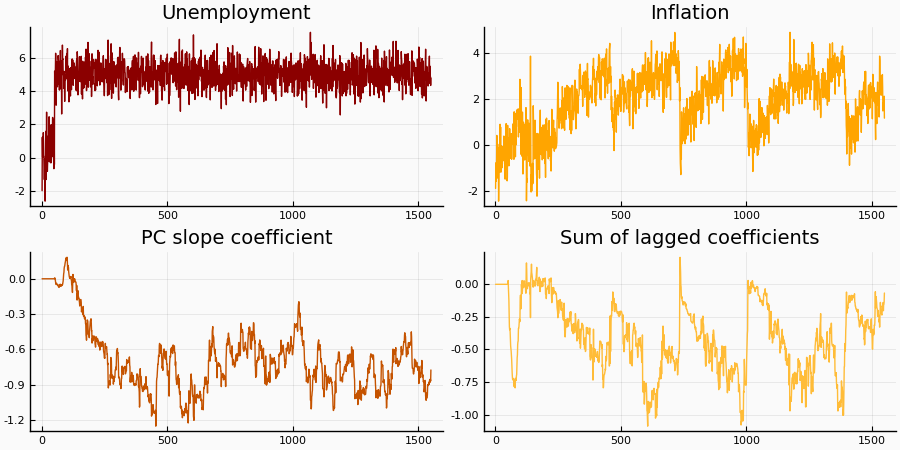

In [62]:
ce = ConquestEconomy(); set_exp!(ce, 1)
simul_reest(ce, 1500)

In [ ]:
ce = ConquestEconomy(Mu=5,My=7) # With more lags in the government's specification, similar dynamics emerge but the pattern becomes more complicated
simul_reest(ce, 2500)

In [ ]:
ce = ConquestEconomy(); set_exp!(ce, 2)
simul_reest(ce, 2500)

In [ ]:
ce = ConquestEconomy(); set_exp!(ce, 3)
simul_reest(ce, 500)